In [25]:
# Python Code for Group Work Machine Learning
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import json_normalize
import glob

In [26]:
df_clustered = pd.read_json('df_slim_rotterdam_modified.json', orient='records', lines=True)

In [27]:
df_clustered.head()

,navigation.time,navigation.location.long,navigation.location.lat,navigation.destination.name,navigation.destination.eta,navigation.status,device.mmsi,vessel.type,vessel.imo,vessel.name,day,hour,minute,cluster
0,1609459588000,4.00828,51.95784,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,6,0
1,1609459769000,4.00827,51.95786,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,9,0
2,1609459948000,4.00828,51.95784,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,12,0
3,1609459948000,4.00828,51.95784,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,12,0
4,1609460669000,4.00828,51.95786,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,24,0


In [28]:
# Add the 'entry' column to indicate if the cluster value changes from the previous row
df_clustered['entry'] = (df_clustered['cluster'] != df_clustered['cluster'].shift()).astype(int)

In [29]:
df_clustered.head()

,navigation.time,navigation.location.long,navigation.location.lat,navigation.destination.name,navigation.destination.eta,navigation.status,device.mmsi,vessel.type,vessel.imo,vessel.name,day,hour,minute,cluster,entry
0,1609459588000,4.00828,51.95784,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,6,0,1
1,1609459769000,4.00827,51.95786,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,9,0,0
2,1609459948000,4.00828,51.95784,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,12,0,0
3,1609459948000,4.00828,51.95784,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,12,0,0
4,1609460669000,4.00828,51.95786,MAASVLAKTE,2021-12-31T16:59:00+00:00,moored,211560210,cargo,0,AARBURG,1,0,24,0,0


In [ ]:
# df_clustered.to_excel('df_clustered_exported.xlsx', index=False, sheet_name='Clustered Data')

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np

# Preprocess the data
features = ['navigation.location.long', 'navigation.location.lat', 'vessel.name', 'day', 'hour']

# Encode categorical feature 'vessel.name'
le = LabelEncoder()
df_clustered['vessel.name'] = le.fit_transform(df_clustered['vessel.name'])

# Scale numerical features
scaler = MinMaxScaler()
df_clustered[features[:2]] = scaler.fit_transform(df_clustered[features[:2]])

# Prepare input and output data
X = df_clustered[features].values
y = df_clustered[['cluster', 'entry']].values  # Include both 'cluster' and 'entry' as target

# Reshape input data for LSTM (samples, timesteps, features)
sequence_length = 24  # Define the sequence length
X_lstm = []
y_lstm = []
for i in range(len(X) - sequence_length):
    X_lstm.append(X[i:i + sequence_length])
    y_lstm.append(y[i + sequence_length])
X_lstm = np.array(X_lstm)
y_lstm = np.array(y_lstm)

# Split data into training, validation, and testing sets
train_size = int(0.6 * len(X_lstm))
val_size = int(0.2 * len(X_lstm))
X_train, X_val, X_test = X_lstm[:train_size], X_lstm[train_size:train_size + val_size], X_lstm[train_size + val_size:]
y_train, y_val, y_test = y_lstm[:train_size], y_lstm[train_size:train_size + val_size], y_lstm[train_size + val_size:]

# Build the LSTM model
num_features = X_train.shape[2]
num_targets = y_train.shape[1]  # Number of target columns
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, num_features)))
model.add(Dropout(0.25))
model.add(LSTM(units=50))
model.add(Dropout(0.25))
model.add(Dense(units=num_targets))  # Output layer with two units for 'cluster' and 'entry'

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=12, batch_size=32, validation_data=(X_val, y_val))


c:\Users\malyd\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/12
577/577 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.2978 - val_loss: 0.7755
Epoch 2/12
577/577 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0874 - val_loss: 0.7892
Epoch 3/12
577/577 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0652 - val_loss: 0.8144
Epoch 4/12
577/577 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0524 - val_loss: 0.7771
Epoch 5/12
577/577 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0447 - val_loss: 0.7758
Epoch 6/12
577/577 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0496 - val_loss: 0.8312
Epoch 7/12
577/577 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0380 - val_loss: 0.7727
Epoch 8/12
577/577 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0347 - val_loss: 0.8331
Epoch 9/12
577/577 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0350 - val_loss: 0.8256
Epoch 10/12
577/577 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0343 - val_loss: 0.8641
Epoch 11/12
577/577 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0452 - val_loss: 0.8407
Epoch 12/12
577/577 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np

# Preprocess the data
features = ['navigation.location.long', 'navigation.location.lat', 'vessel.name', 'day', 'hour']

# Encode categorical feature 'vessel.name'
le = LabelEncoder()
df_clustered['vessel.name'] = le.fit_transform(df_clustered['vessel.name'])

# Scale numerical features
scaler = MinMaxScaler()
df_clustered[features[:2]] = scaler.fit_transform(df_clustered[features[:2]])

# Prepare input and output data
X = df_clustered[features].values
y = df_clustered[['cluster', 'entry']].values  # Include both 'cluster' and 'entry' as target

# Reshape input data for LSTM (samples, timesteps, features)
sequence_length = 24  # Define the sequence length
X_lstm = []
y_lstm = []
for i in range(len(X) - sequence_length):
    X_lstm.append(X[i:i + sequence_length])
    y_lstm.append(y[i + sequence_length])
X_lstm = np.array(X_lstm)
y_lstm = np.array(y_lstm)

# Split data into training and validation sets
train_size = int(0.9 * len(X_lstm))
X_train, X_val = X_lstm[:train_size], X_lstm[train_size:]
y_train, y_val = y_lstm[:train_size], y_lstm[train_size:]

# Build the LSTM model
num_features = X_train.shape[2]
num_targets = y_train.shape[1]  # Number of target columns
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, num_features)))
model.add(Dropout(0.25))
model.add(LSTM(units=50))
model.add(Dropout(0.25))
model.add(Dense(units=num_targets))  # Output layer with two units for 'cluster' and 'entry'

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=18, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/24


c:\Users\malyd\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


865/865 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - loss: 0.4923 - val_loss: 0.4931
Epoch 2/24
865/865 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.1782 - val_loss: 0.4898
Epoch 3/24
865/865 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.1059 - val_loss: 0.1439
Epoch 4/24
865/865 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.0771 - val_loss: 0.3204
Epoch 5/24
865/865 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0700 - val_loss: 0.1420
Epoch 6/24
865/865 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0670 - val_loss: 0.1989
Epoch 7/24
865/865 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.0587 - val_loss: 0.1704
Epoch 8/24
865/865 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.0542 - val_loss: 0.1979
Epoch 9/24
865/865 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.0652 - val_loss: 0.1245
Epoch 10/24
865/865 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0516 - val_loss: 0.1456
Epoch 11/24
865/865 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.0997 - val_loss: 0.2781
Epoch 12/24
865/865 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Preprocess the data
features = ['navigation.location.long', 'navigation.location.lat', 'vessel.name', 'day', 'hour']

# Encode categorical feature 'vessel.name'
le = LabelEncoder()
df_clustered['vessel.name'] = le.fit_transform(df_clustered['vessel.name'])

# Scale numerical features
scaler = MinMaxScaler()
df_clustered[features[:2]] = scaler.fit_transform(df_clustered[features[:2]])

# Group the data by 'vessel.name' and sort each group by 'day', 'hour', and 'minute'
df_clustered_sorted = df_clustered.sort_values(by=['vessel.name', 'day', 'hour', 'minute'])

# Prepare input and output data dynamically
X_dynamic = []
y_dynamic = []

# Iterate through each group of 'vessel.name'
for vessel_name, group in df_clustered_sorted.groupby('vessel.name'):
    group_features = group[features].values
    group_targets = group[['cluster', 'entry']].values
    
    # Create sequences for the current group
    for i in range(len(group_features)):
        X_dynamic.append(group_features[:i + 1])  # Include all rows up to the current index
        y_dynamic.append(group_targets[i])  # Target is the current row's target

# Pad sequences to the maximum sequence length
from keras.preprocessing.sequence import pad_sequences

max_sequence_length = max(len(seq) for seq in X_dynamic)
X_padded = pad_sequences(X_dynamic, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')
y_padded = np.array(y_dynamic)

# Split data into training and validation sets
train_size = int(0.9 * len(X_padded))
X_train, X_val = X_padded[:train_size], X_padded[train_size:]
y_train, y_val = y_padded[:train_size], y_padded[train_size:]

# Print the shapes of the padded data
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)


X_train shape: (27699, 8906, 5)
X_val shape: (3078, 8906, 5)
y_train shape: (27699, 2)
y_val shape: (3078, 2)


In [19]:
#Output the number of data points in training, validation, and test dataset.
print("Datapoints in Training set:",len(X_train))
print("Datapoints in validation set:",len(X_val))

Datapoints in Training set: 27677
Datapoints in validation set: 3076


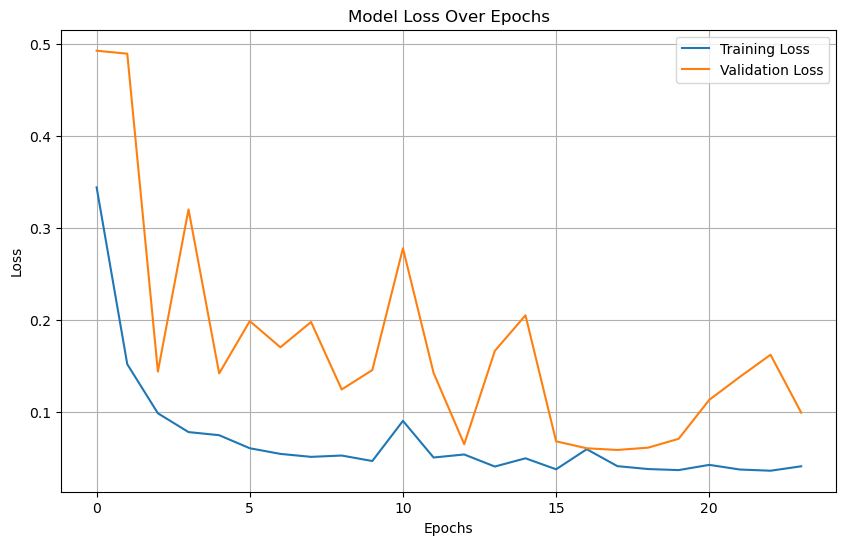

In [24]:
# Visualize the training and validation loss
history = model.history.history  # Assuming the model's training history is stored in `model.history`

plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Training Loss')
if 'val_loss' in history:
    plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
df_clustered['cluster'].value_counts()

cluster
0    15047
1     6498
2     5109
3     2849
4     1274
Name: count, dtype: int64

In [5]:
df_cluster_0 = df_clustered[df_clustered['cluster'] == 0]
df_cluster_1 = df_clustered[df_clustered['cluster'] == 1]
df_cluster_2 = df_clustered[df_clustered['cluster'] == 2]
df_cluster_3 = df_clustered[df_clustered['cluster'] == 3]
df_cluster_4 = df_clustered[df_clustered['cluster'] == 4]

In [6]:
import ipywidgets as widgets
from IPython.display import display
from mpl_toolkits.basemap import Basemap

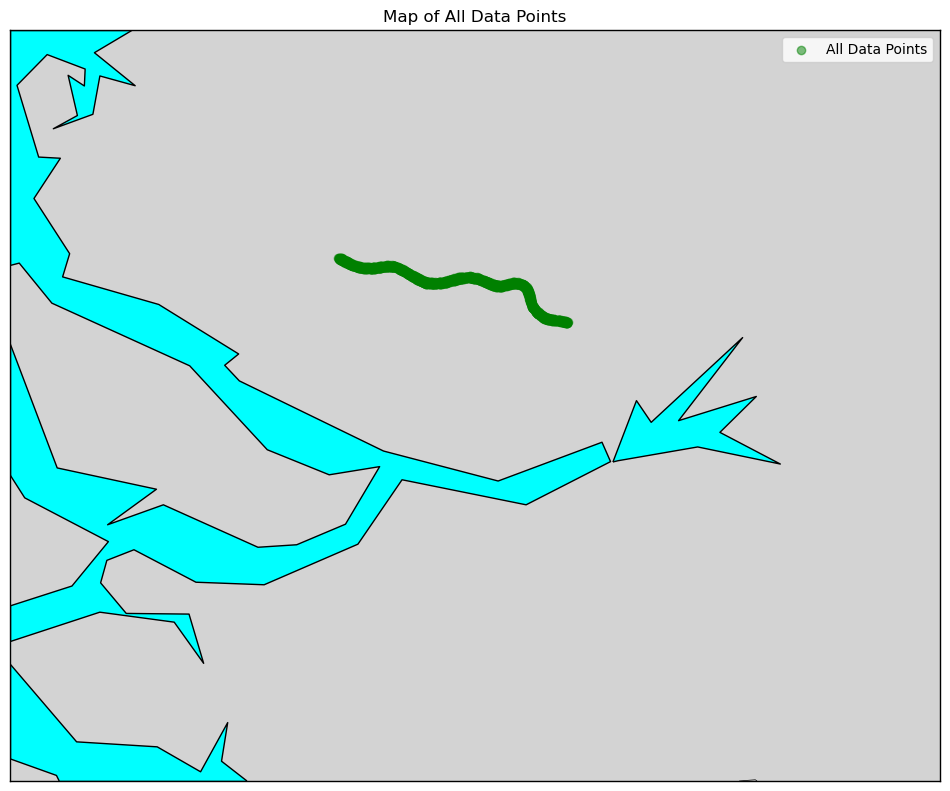

In [7]:
# Create a map to plot datapoints from df_all
fig, ax = plt.subplots(figsize=(12, 12))

# Initialize the Basemap
m3 = Basemap(projection='merc', llcrnrlat=51.5, urcrnrlat=52.0,
             llcrnrlon=4.0, urcrnrlon=5.0, resolution='i', ax=ax)

# Draw coastlines, countries, and map boundaries
m3.drawcoastlines()
m3.drawcountries()
m3.drawmapboundary(fill_color='aqua')
m3.fillcontinents(color='lightgray', lake_color='aqua')

# Plot the datapoints from df_all
x_all, y_all = m3(df_cluster_4['navigation.location.long'].values,
                  df_cluster_4['navigation.location.lat'].values)
ax.scatter(x_all, y_all, marker='o', color='green', alpha=0.5, label='All Data Points')

ax.legend()
ax.set_title('Map of All Data Points')

plt.show()

In [10]:
for i in range(5):
    print(f"Cluster {i} vessel.name value counts:")
    print(eval(f"df_cluster_{i}['vessel.name'].value_counts()"))
    print("\n")

Cluster 0 vessel.name value counts:
vessel.name
JORDY-M     7103
LEVANTE     2222
ROMEE       1824
AARBURG     1619
CAAN        1512
TRUDIE       517
CHARLOIS     250
Name: count, dtype: int64


Cluster 1 vessel.name value counts:
vessel.name
TRUDIE      2593
AARBURG     1071
CAAN        1025
JORDY-M      894
ROMEE        573
LEVANTE      292
CHARLOIS      50
Name: count, dtype: int64


Cluster 2 vessel.name value counts:
vessel.name
CHARLOIS    4102
LEVANTE      295
JORDY-M      263
AARBURG      235
CAAN         121
TRUDIE        74
ROMEE         19
Name: count, dtype: int64


Cluster 3 vessel.name value counts:
vessel.name
LEVANTE     1266
JORDY-M      646
ROMEE        508
CAAN         207
TRUDIE       150
CHARLOIS      49
AARBURG       23
Name: count, dtype: int64


Cluster 4 vessel.name value counts:
vessel.name
LEVANTE     443
ROMEE       323
CHARLOIS    211
CAAN        166
TRUDIE       79
AARBURG      52
Name: count, dtype: int64




In [11]:
# Find vessel names that appear in all clusters
vessels_in_all_clusters = set.intersection(
    *[set(df_clustered[df_clustered['cluster'] == cluster]['vessel.name']) for cluster in range(5)]
)

# Filter the dataframe for these vessel names and count their occurrences
vessel_counts = df_clustered[df_clustered['vessel.name'].isin(vessels_in_all_clusters)]['vessel.name'].value_counts()

print(vessel_counts)

vessel.name
CHARLOIS    4662
LEVANTE     4518
TRUDIE      3413
ROMEE       3247
CAAN        3031
AARBURG     3000
Name: count, dtype: int64


In [12]:
df_longroute_vessel = df_clustered[df_clustered['vessel.name'].isin(['CHARLOIS', 'LEVANTE', 'TRUDIE', 'ROMEE', 'CAAN', 'AARBURG'])]

In [13]:
# Group data by cluster and time to count the number of ships entering each cluster zone
df_longroute_vessel['navigation.time'] = pd.to_datetime(df_longroute_vessel['navigation.time'], unit='ms')
df_longroute_vessel.set_index('navigation.time', inplace=True)
cluster_counts = df_longroute_vessel.groupby([pd.Grouper(freq='D'), 'cluster']).size().unstack(fill_value=0)

# Group data by day, hour, and cluster to count the number of ships entering each cluster zone
hourly_cluster_counts = df_longroute_vessel.groupby(['day', 'hour', 'cluster']).size().unstack(fill_value=0)

# Display the result
hourly_cluster_counts

C:\Users\malyd\AppData\Local\Temp\ipykernel_20456\3912969994.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_longroute_vessel['navigation.time'] = pd.to_datetime(df_longroute_vessel['navigation.time'], unit='ms')


cluster    0   1   2  3  4
day hour                  
1   0     11   0  12  0  0
    1     12   0  12  0  0
    2     12   0  12  0  0
    3     12   0  12  0  0
    4     12   0  12  0  0
...       ..  ..  .. .. ..
31  19    12  11   0  0  0
    20    12  12   0  0  0
    21    12  12   0  0  0
    22    12  12   0  0  0
    23    12  12   0  0  0

[719 rows x 5 columns]

In [14]:
hourly_cluster_counts.to_excel('hourly_counts_longroute.xlsx', sheet_name='Hourly Cluster Counts')

In [9]:
df_c4_levante = df_cluster_4[df_cluster_4['vessel.name'] == 'LEVANTE']
df_c4_levante.head()

,navigation.time,navigation.location.long,navigation.location.lat,navigation.destination.name,navigation.destination.eta,navigation.status,device.mmsi,vessel.type,vessel.imo,vessel.name,day,hour,minute,cluster
2742,1609585315000,4.58028,51.80837,OCT -- EUROPOORT VV,2021-10-10T00:00:00+00:00,under-way-using-engine,244010773,cargo,0,LEVANTE,2,11,1,4
2743,1609585612000,4.56193,51.81652,OCT -- EUROPOORT VV,2021-10-10T00:00:00+00:00,under-way-using-engine,244010773,cargo,0,LEVANTE,2,11,6,4
2744,1609585903000,4.55547,51.82950,OCT -- EUROPOORT VV,2021-10-10T00:00:00+00:00,under-way-using-engine,244010773,cargo,0,LEVANTE,2,11,11,4
2745,1609586213000,4.53403,51.83146,OCT -- EUROPOORT VV,2021-10-10T00:00:00+00:00,under-way-using-engine,244010773,cargo,0,LEVANTE,2,11,16,4
2746,1609586513000,4.51229,51.83317,OCT -- EUROPOORT VV,2021-10-10T00:00:00+00:00,under-way-using-engine,244010773,cargo,0,LEVANTE,2,11,21,4


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
from collections import Counter
import time
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report

In [11]:
X1 = df_clustered[['navigation.location.long', 'navigation.location.lat', 'day', 'hour']].values
X2 = df_clustered['vessel.name']
LE = preprocessing.LabelEncoder()
LE.fit(X2)
X2 = LE.transform(X2).reshape(-1, 1)  # Reshape X2 to make it a 2D array
X = np.hstack((X1, X2))  # Combine X1 and X2 horizontally
X

array([[ 4.00828, 51.95784,  1.     ,  0.     ,  0.     ],
       [ 4.00827, 51.95786,  1.     ,  0.     ,  0.     ],
       [ 4.00828, 51.95784,  1.     ,  0.     ,  0.     ],
       ...,
       [ 4.32555, 51.88149, 29.     , 16.     ,  5.     ],
       [ 4.33281, 51.86744, 29.     , 16.     ,  5.     ],
       [ 4.34371, 51.8549 , 29.     , 16.     ,  5.     ]])

In [12]:
y = df_clustered['cluster'].values
y

array([0, 0, 0, ..., 2, 3, 3], dtype=int64)

In [13]:
# Group data by cluster and time to count the number of ships entering each cluster zone
df_clustered['navigation.time'] = pd.to_datetime(df_clustered['navigation.time'], unit='ms')
df_clustered.set_index('navigation.time', inplace=True)
cluster_counts = df_clustered.groupby([pd.Grouper(freq='D'), 'cluster']).size().unstack(fill_value=0)

In [14]:
cluster_counts

cluster,0,1,2,3,4
navigation.time,,,,,
2021-01-01,577,0,65,2,18
2021-01-02,704,0,0,16,11
2021-01-03,680,9,158,21,31
2021-01-04,461,328,337,71,27
2021-01-05,382,575,468,53,13
2021-01-06,435,134,262,35,46
2021-01-07,674,188,49,203,42
2021-01-08,323,235,185,241,82
2021-01-09,400,140,47,126,47


In [15]:
# Group data by day, hour, and cluster to count the number of ships entering each cluster zone
hourly_cluster_counts = df_clustered.groupby(['day', 'hour', 'cluster']).size().unstack(fill_value=0)

# Display the result
hourly_cluster_counts

cluster    0   1   2  3  4
day hour                  
1   0     23   0  12  0  0
    1     24   0  12  0  0
    2     24   0  12  0  0
    3     24   0  12  0  0
    4     24   0  12  0  0
...       ..  ..  .. .. ..
31  19    24  11   0  0  0
    20    24  12   0  0  0
    21    23  12   0  0  0
    22    25  12   0  0  0
    23    24  12   0  0  0

[744 rows x 5 columns]

In [ ]:
hourly_cluster_counts.to_excel('hourly_cluster_counts.xlsx', sheet_name='Hourly Cluster Counts')

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Prepare the data for time-series forecasting
hourly_cluster_counts = hourly_cluster_counts.reset_index()
hourly_cluster_counts['time_index'] = range(len(hourly_cluster_counts))

# Shift the data to create lag features for forecasting
lags = 8  # Number of lag hours to use as features
for i in range(1, lags + 1):
    for cluster in hourly_cluster_counts.columns[2:]:
        hourly_cluster_counts[f'{cluster}_lag_{i}'] = hourly_cluster_counts[cluster].shift(i)

# Drop rows with NaN values due to lagging
hourly_cluster_counts = hourly_cluster_counts.dropna()

# Split the data into training and testing sets
X = hourly_cluster_counts[[f'{cluster}_lag_{i}' for cluster in hourly_cluster_counts.columns[2:7] for i in range(1, lags + 1)]]
y = hourly_cluster_counts[hourly_cluster_counts.columns[2:7]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor for each cluster
models = {}
predictions = {}
for cluster in y.columns:
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train[cluster])
    models[cluster] = model
    predictions[cluster] = model.predict(X_test)

# Evaluate the models
for cluster in y.columns:
    mse = mean_squared_error(y_test[cluster], predictions[cluster])
    print(f"Cluster {cluster}: Mean Squared Error = {mse}")

# Predict future hourly counts for each cluster
future_hours = 24  # Number of hours to predict
future_predictions = pd.DataFrame(index=range(future_hours), columns=y.columns)

for cluster in y.columns:
    future_data = X.iloc[-1:].copy()  # Start with the last row of the training data
    for hour in range(future_hours):
        prediction = models[cluster].predict(future_data)[0]
        future_predictions.loc[hour, cluster] = prediction
        # Update future_data with the new prediction
        for lag in range(lags, 0, -1):
            if lag > 1:
                future_data[f'{cluster}_lag_{lag}'] = future_data[f'{cluster}_lag_{lag-1}']
            else:
                future_data[f'{cluster}_lag_{lag}'] = prediction

print("Future Predictions:")
print(future_predictions)


C:\Users\malyd\AppData\Local\Temp\ipykernel_12576\1277267656.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hourly_cluster_counts[f'{cluster}_lag_{i}'] = hourly_cluster_counts[cluster].shift(i)
C:\Users\malyd\AppData\Local\Temp\ipykernel_12576\1277267656.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hourly_cluster_counts[f'{cluster}_lag_{i}'] = hourly_cluster_counts[cluster].shift(i)
C:\Users\malyd\AppData\Local\Temp\ipykernel_12576\1277267656.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usual

Cluster 0: Mean Squared Error = 18.81015845070423
Cluster 1: Mean Squared Error = 16.970230142859137
Cluster 2: Mean Squared Error = 10.649992253521125
Cluster 3: Mean Squared Error = 12.181083098591548
Cluster 4: Mean Squared Error = 10.298670185797324
Future Predictions:
cluster      0      1    2    3    4
0        23.67   12.0  0.0  0.0  0.0
1        23.51   12.0  0.0  0.0  0.0
2        23.64   12.0  0.0  0.0  0.0
3        23.63  11.96  0.0  0.0  0.0
4         23.7   12.0  0.0  0.0  0.0
5        23.63   12.0  0.0  0.0  0.0
6        23.72   12.0  0.0  0.0  0.0
7        23.66   12.0  0.0  0.0  0.0
8        23.64   12.0  0.0  0.0  0.0
9        23.64   12.0  0.0  0.0  0.0
10       23.64   12.0  0.0  0.0  0.0
11       23.64   12.0  0.0  0.0  0.0
12       23.64   12.0  0.0  0.0  0.0
13       23.64   12.0  0.0  0.0  0.0
14       23.64   12.0  0.0  0.0  0.0
15       23.64   12.0  0.0  0.0  0.0
16       23.64   12.0  0.0  0.0  0.0
17       23.64   12.0  0.0  0.0  0.0
18       23.64   12.0  

In [13]:
#%%

#splitting dataset into train, validation and test data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 0)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.25,random_state = 0)

# Scale data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


#Output the number of data points in training, validation, and test dataset.
print("Datapoints in Training set:",len(X_train))
print("Datapoints in validation set:",len(X_val))
print("Datapoints in Test set:",len(X_test))

# Convert the y variable into one-hot encoding - basically the true label will be 1 and all others will be assigned to 0
def one_hot(y, num_classes):
    return np.eye(num_classes)[y]

y_train_oh = one_hot(y_train, len(np.unique(y)))
y_val_oh = one_hot(y_val, len(np.unique(y)))
y_test_oh = one_hot(y_test, len(np.unique(y)))

Datapoints in Training set: 18465
Datapoints in validation set: 6156
Datapoints in Test set: 6156


Cost after 0 iterations is : 3.6357343771302553
Cost after 100 iterations is : 0.8741851802814443
Cost after 200 iterations is : 0.7203470220506708
Cost after 300 iterations is : 0.6666651640917125
Cost after 400 iterations is : 0.6339782632545579
Cost after 500 iterations is : 0.6102479060504296
Cost after 600 iterations is : 0.5919059526859296
Cost after 700 iterations is : 0.5771334835081745
Cost after 800 iterations is : 0.5647954441314089
Cost after 900 iterations is : 0.5541697569386859


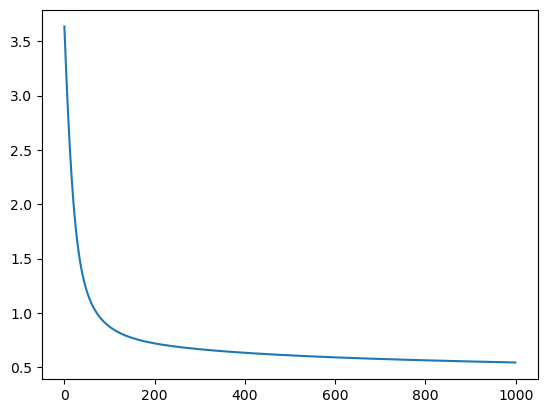

Accuracy on the Train Dataset 77.53 %
Accuracy on the Validation Dataset 76.38 %


In [14]:
# %% -------------  PART A -------------------
#Train NN models to obtain the accuracy on the test data using your training and validation data.
#Simple Neural Network from Scratch with One Hidden Layer 
#Forward and backward propogation are to be implemented in detail 
#Missing parts that you need to implement to answer the question are indicated below (with "Implement!")


#activation functions 
def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(x, 0)

def softmax(x):
    expX = np.exp(x)
    return expX/np.sum(expX, axis = 0)

#derivatives - activation functions - to be used in backward progation of errors
def derivative_tanh(x):
    return (1 - np.power(np.tanh(x), 2))

def derivative_relu(x):
    return np.array(x > 0, dtype = np.float32)

#n_x number of features aka input variables
#n_h number of neurons in the hidden layer 
#n_y number of classes 


#definition of parameters (theta) between each input in the input layer, each neuron in the hidden layer, and output in the output layer
def initialize_parameters(n_x, n_h, n_y):
    theta_1 = np.random.randn(n_h, n_x)#*0.1  scaling used for the case of RELU 
    theta0_1 = np.zeros((n_h, 1))
    
    theta_2 = np.random.randn(n_y, n_h)#*0.1  scaling used for the case of RELU 
    theta0_2 = np.zeros((n_y, 1))
    
    parameters = {
        "theta_1" : theta_1,  
        "theta0_1" : theta0_1, #bias / intercept from the input layer
        "theta_2" : theta_2,
        "theta0_2" : theta0_2 #bias / intercept from the hidden layer
    }
    
    return parameters

def forward_propagation(x, parameters):
    
    theta_1 = parameters['theta_1']
    theta0_1 = parameters['theta0_1']
    theta_2 = parameters['theta_2']
    theta0_2 = parameters['theta0_2']
    
    # !!!!!!! IMPLEMENT !!!!!!!!!!!!!!!!
    #linear combination of first set of parameters and the inputs 
    x1 = np.dot(theta_1, x) + theta0_1
    xh1 = tanh(x1) #activation function
    #linear combination of the second set of parameteres and the output of the hidden layer
    x2 = np.dot(theta_2, xh1) + theta0_2
    xh2 = softmax(x2) #softmax function at the output layer for the classification task
    
    forward_cache = {
        "x1" : x1,
        "xh1" : xh1,
        "x2" : x2,
        "xh2" : xh2
    }
    
    return forward_cache

def cost_function(xh2, y):
    m = y.shape[1]
    #cross-entropy loss (also in your slides - for multiclass classification with softmax)
    cost = -(1/m)*np.sum(y*np.log(xh2))
    return cost

def backward_prop(x, y, parameters, forward_cache):
    
    theta_1 = parameters['theta_1']
    theta0_1 = parameters['theta0_1']
    theta_2 = parameters['theta_2']
    theta0_2 = parameters['theta0_2']
    
    xh1 = forward_cache['xh1']
    xh2 = forward_cache['xh2']
    
    m = x.shape[1]
    
    dx2 = (xh2 - y)  #output layer with the softmax - partial derivative with respect to x2, this is given to you and have quite some derivations behind 
    
    #partial derivative with respect to the second set of parameters based on the error above
    dtheta_2 = (1/m)*np.dot(dx2, xh1.T)
    dtheta0_2 = (1/m)*np.sum(dx2, axis = 1, keepdims = True)
    
    #error propagated to the hidden layer 
    dx1 = (1/m)*np.dot(theta_2.T, dx2)*derivative_tanh(xh1)  #needs to be tailored to the chosen activation function at the hidden layer
    
    # !!!!!!! IMPLEMENT !!!!!!!!!!!!!!!!
    #partial derivative with respect to the first set of parameters based on the error above
    dtheta_1 = (1/m)*np.dot(dx1, x.T)
    dtheta0_1 = (1/m)*np.sum(dx1, axis = 1, keepdims = True)
    
    gradients = {
        "dtheta_1" : dtheta_1,
        "dtheta0_1" : dtheta0_1,
        "dtheta_2" : dtheta_2,
        "dtheta0_2" : dtheta0_2
    }
    
    return gradients

def update_parameters(parameters, gradients, learning_rate):
    
    theta_1 = parameters['theta_1']
    theta0_1 = parameters['theta0_1']
    theta_2 = parameters['theta_2']
    theta0_2 = parameters['theta0_2']
    
    dtheta_1 = gradients['dtheta_1']
    dtheta0_1 = gradients['dtheta0_1']
    dtheta_2 = gradients['dtheta_2']
    dtheta0_2 = gradients['dtheta0_2']
    
    #update of the first and second set of parameters based on the partial derivatives (gradients) and the learning rate
    theta_1 = theta_1 - learning_rate*dtheta_1
    theta0_1 = theta0_1 - learning_rate*dtheta0_1
    theta_2 = theta_2 - learning_rate*dtheta_2
    theta0_2 = theta0_2 - learning_rate*dtheta0_2
    
    parameters = {
        "theta_1" : theta_1,
        "theta0_1" : theta0_1,
        "theta_2" : theta_2,
        "theta0_2" : theta0_2
    }
    
    return parameters

def NN_singleHiddenLayer(x, y, n_h, learning_rate, iterations):
    
    n_x = x.shape[0]
    n_y = y.shape[0]
    
    cost_list = []
    
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    for i in range(iterations):
        
        forward_cache = forward_propagation(x, parameters)
        
        cost = cost_function(forward_cache['xh2'], y)
        
        gradients = backward_prop(x, y, parameters, forward_cache)
        
        parameters = update_parameters(parameters, gradients, learning_rate)
        
        cost_list.append(cost)
        
        if(i%(iterations/10) == 0):
            print("Cost after", i, "iterations is :", cost)
        
    return parameters, cost_list

iterations = 1000
n_h = 10
learning_rate = 0.05
Parameters, Cost_list = NN_singleHiddenLayer(X_train.T, y_train_oh.T, n_h = n_h, learning_rate = learning_rate, iterations = iterations)

t = np.arange(0, iterations)
plt.plot(t, Cost_list)
plt.show()

#accuracy function based on a test/validation dataset 
def accuracy(inp, labels, parameters):
    forward_cache = forward_propagation(inp, parameters)
    y_out = forward_cache['xh2']   # containes propabilities with shape(6, 1)
    y_out = np.argmax(y_out, 0)  # 0 represents row wise 
    labels = np.argmax(labels, 0)
    acc = np.mean(y_out == labels)*100
    
    return acc

print("Accuracy on the Train Dataset", round(accuracy(X_train.T, y_train_oh.T, Parameters),2), "%")
print("Accuracy on the Validation Dataset", round(accuracy(X_val.T, y_val_oh.T, Parameters), 2), "%")

In [15]:
# %% -------------  PART B -------------------
#Now Train NN models using SKLEARN 
#Logistic regression (that can handle multi class classification) is provided for you. 

#Missing parts that you need to implement to answer the question are indicated below (with "Implement!")


from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

train_logreg = LogisticRegression(random_state=0,max_iter = 200).fit(X_train,y_train)

# !!!!!!! IMPLEMENT !!!!!!!!!!!!!!!!
# Train a Neural Network
# train_nn = MLPClassifier(hidden_layer_sizes=(n_h,), max_iter=iterations, alpha=0.01,
#                      solver='sgd', verbose=10,  random_state=21,tol=0.000000001)
# train_nn.fit(X_train, y_train)

# Train a Neural Network with deeper layers
train_nn = MLPClassifier(hidden_layer_sizes=(n_h, n_h, n_h), max_iter=iterations, alpha=0.01,
                     solver='sgd', verbose=10, random_state=21, tol=0.000000001)
train_nn.fit(X_train, y_train)

pred_logreg = train_logreg.predict(X_val)
print("For Logistic Regression: ")
print(classification_report(y_val, pred_logreg))
print ("Accuracy of logistic regression on the initial data is: ",accuracy_score(pred_logreg,y_val))

# !!!!!!! IMPLEMENT !!!!!!!!!!!!!!!!
#Predict based on the trained Neural Network using the validation data
#NOTE: You should reach a NN which has a better accuracy than the logistic regression, if  not revisit the specification of your NN

pred_nn = train_nn.predict(X_val)
print("For Neural Network: ")
print(classification_report(y_val, pred_nn))
print ("Accuracy of NN on the initial data is: ",accuracy_score(pred_nn,y_val))

Iteration 1, loss = 1.63827646
Iteration 2, loss = 1.28779516
Iteration 3, loss = 1.09748528
Iteration 4, loss = 0.97675236
Iteration 5, loss = 0.89601122
Iteration 6, loss = 0.83658227
Iteration 7, loss = 0.78812698
Iteration 8, loss = 0.74640456
Iteration 9, loss = 0.70976263
Iteration 10, loss = 0.67702119
Iteration 11, loss = 0.64690046
Iteration 12, loss = 0.61827652
Iteration 13, loss = 0.59112144
Iteration 14, loss = 0.56528504
Iteration 15, loss = 0.54024436
Iteration 16, loss = 0.51606622
Iteration 17, loss = 0.49349883
Iteration 18, loss = 0.47287144
Iteration 19, loss = 0.45402852
Iteration 20, loss = 0.43636031
Iteration 21, loss = 0.41961754
Iteration 22, loss = 0.40352388
Iteration 23, loss = 0.38828626
Iteration 24, loss = 0.37363942
Iteration 25, loss = 0.35959131
Iteration 26, loss = 0.34608459
Iteration 27, loss = 0.33306238
Iteration 28, loss = 0.32063011
Iteration 29, loss = 0.30867326
Iteration 30, loss = 0.29734526
Iteration 31, loss = 0.28656369
Iteration 32, los

In [16]:
final_res = train_nn.predict(X_test)
print("For Neural Network: ")
print(classification_report(y_test, final_res))
print ("Accuracy of the chosen Classifier is: ",accuracy_score(final_res,y_test))

For Neural Network: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3004
           1       1.00      1.00      1.00      1308
           2       1.00      1.00      1.00      1021
           3       0.99      1.00      1.00       552
           4       1.00      1.00      1.00       271

    accuracy                           1.00      6156
   macro avg       1.00      1.00      1.00      6156
weighted avg       1.00      1.00      1.00      6156

Accuracy of the chosen Classifier is:  0.9987004548408057


In [29]:
# %% -------------  PART C -------------------
#We can also extract features such as minute, hour and day from timestamp column as it was not used till now and try to improve the above accuracies

#Feature Extraction from Timestamp hour, minute, day
#Again training the classifiers
X = df_cluster_4[['navigation.location.long', 'navigation.location.lat', 'day', 'hour', 'minute']].values
y = df_cluster_4['vessel.name']
LE = preprocessing.LabelEncoder()
LE.fit(y)
y = LE.transform(y)
y

#splitting dataset into train, validation and test data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 0)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.25,random_state = 0)

# Scale data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert the y variable into one-hot encoding - basically the true label will be 1 and all others will be assigned to 0
def one_hot(y, num_classes):
    return np.eye(num_classes)[y]

y_train_oh = one_hot(y_train, len(np.unique(y)))
y_val_oh = one_hot(y_val, len(np.unique(y)))
y_test_oh = one_hot(y_test, len(np.unique(y)))

train_logreg2 = LogisticRegression(random_state=0,max_iter = 200).fit(X_train,y_train)

# !!!!!!! IMPLEMENT !!!!!!!!!!!!!!!!
#Train a NN with more features as explained above 

# basic NN
# train_nn2 = MLPClassifier(hidden_layer_sizes=(n_h,), max_iter=iterations, alpha=0.01,
#                      solver='sgd', verbose=10,  random_state=21,tol=0.000000001)

# deeper NN
train_nn2 = MLPClassifier(hidden_layer_sizes=(2*n_h, 2*n_h, n_h), max_iter=iterations, alpha=0.01,
                     solver='sgd', verbose=10, random_state=21, tol=0.000000001)

train_nn2.fit(X_train, y_train)

pred_logreg2 = train_logreg2.predict(X_val)
print("For Logistic Regression: ")
print(classification_report(y_val, pred_logreg2))
print ("Accuracy of logistic regression on the extended data is: ",accuracy_score(pred_logreg2,y_val))

# !!!!!!! IMPLEMENT !!!!!!!!!!!!!!!!
# Predict based on the trained NN using the validation data
#NOTE: Again you should reach a NN which has a better accuracy than the logistic regression, if  not revisit the specification of your NN


pred_nn2 = train_nn2.predict(X_val)
print("For Neural Network: ")
print(classification_report(y_val, pred_nn2))
print ("Accuracy of NN on the extended data is: ",accuracy_score(pred_nn2,y_val))

Iteration 1, loss = 1.92183890
Iteration 2, loss = 1.91633259
Iteration 3, loss = 1.90831156
Iteration 4, loss = 1.89866002
Iteration 5, loss = 1.88847517
Iteration 6, loss = 1.87834019
Iteration 7, loss = 1.86827366
Iteration 8, loss = 1.85841094
Iteration 9, loss = 1.84916713
Iteration 10, loss = 1.84032905
Iteration 11, loss = 1.83184582
Iteration 12, loss = 1.82392683
Iteration 13, loss = 1.81620610
Iteration 14, loss = 1.80890025
Iteration 15, loss = 1.80198950
Iteration 16, loss = 1.79542153
Iteration 17, loss = 1.78911794
Iteration 18, loss = 1.78311255
Iteration 19, loss = 1.77714329
Iteration 20, loss = 1.77172502
Iteration 21, loss = 1.76631635
Iteration 22, loss = 1.76115922
Iteration 23, loss = 1.75622158
Iteration 24, loss = 1.75134359
Iteration 25, loss = 1.74679112
Iteration 26, loss = 1.74220942
Iteration 27, loss = 1.73781831
Iteration 28, loss = 1.73363748
Iteration 29, loss = 1.72957481
Iteration 30, loss = 1.72554274
Iteration 31, loss = 1.72170677
Iteration 32, los

c:\Users\malyd\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\malyd\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\malyd\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\malyd\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-de

In [30]:
# %% -------------  PART D -------------------
#Accuracy of the models should increase by using additional features
#Pick the one with the highest accuracy and apply it to the test data. 

# !!!!!!! IMPLEMENT !!!!!!!!!!!!!!!!
#NOTE you should reach an accuracy of at least 80% so revisit your models if you cannot reach that. 

final_res = train_nn2.predict(X_test)
print("For Neural Network: ")
print(classification_report(y_test, final_res))
print ("Accuracy of the chosen Classifier is: ",accuracy_score(final_res,y_test))

For Neural Network: 
              precision    recall  f1-score   support

           0       0.42      0.67      0.52        12
           1       0.32      0.35      0.33        37
           2       0.67      0.11      0.19        37
           3       0.50      0.64      0.56        84
           4       0.43      0.49      0.46        69
           5       0.00      0.00      0.00        16

    accuracy                           0.44       255
   macro avg       0.39      0.38      0.34       255
weighted avg       0.44      0.44      0.41       255

Accuracy of the chosen Classifier is:  0.44313725490196076
